In [39]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import checkpoint2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from textblob import TextBlob
from IPython.display import HTML
from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold

RANDOM_STATE = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
if not os.path.exists("uber_preprocessed.csv") or not os.path.exists("lyft_preprocessed.csv"):
    uber = pd.read_csv("uber_cleaned.csv").dropna().astype({'Invited': 'int32', "Unfair": 'int32'})
    lyft = pd.read_csv("lyft_cleaned.csv").astype({'Invited': 'int32'})
    uber['# Reviews By User'] = pd.to_numeric(uber['# Reviews By User'], errors='coerce')
    lyft["# Reviews By User"] = pd.to_numeric(lyft['# Reviews By User'], errors='coerce')
    uber = uber.dropna(subset=['# Reviews By User'])
    lyft = lyft.dropna(subset=['# Reviews By User'])
    raw_uber = uber.copy()
    raw_lyft = lyft.copy()


    lyft["Review Body"] = checkpoint2.preprocess_reviews(lyft)
    uber["Review Body"] = checkpoint2.preprocess_reviews(uber)
    uber.to_csv("uber_preprocessed.csv", index=False)
    lyft.to_csv("lyft_preprocessed.csv", index=False)
else:
    raw_uber = pd.read_csv("uber_cleaned.csv").dropna().astype({'Invited': 'int32', "Unfair": 'int32'})
    raw_lyft = pd.read_csv("lyft_cleaned.csv").astype({'Invited': 'int32'})
    raw_uber['# Reviews By User'] = pd.to_numeric(raw_uber['# Reviews By User'], errors='coerce')
    raw_lyft["# Reviews By User"] = pd.to_numeric(raw_lyft['# Reviews By User'], errors='coerce')
    raw_uber = raw_uber.dropna(subset=['# Reviews By User'])
    raw_lyft = raw_lyft.dropna(subset=['# Reviews By User'])


    uber = pd.read_csv("uber_preprocessed.csv")
    lyft = pd.read_csv("lyft_preprocessed.csv")

ALREADY_PREPROCESSED = True

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin

sentiment = checkpoint2.get_weighed_sentiment_counts(checkpoint2.get_sentiment_and_counts(uber))
class SentimentTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        if not ALREADY_PREPROCESSED: X["Review Body"] = checkpoint2.preprocess_reviews(X)
        X["Review Body"] = [str(review) for review in X["Review Body"]]
        X['Sentiment'] = [sum([sentiment[word] if word in sentiment else 0 for word in str(review).split()]) for review in X["Review Body"]]
        return X


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

multinomial_transformer = ColumnTransformer([
    ('title_vect', TfidfVectorizer(max_df=0.5, max_features=18, min_df=0, stop_words='english', sublinear_tf=True, use_idf=False), 'Review Title'), 
    ('body_vect', TfidfVectorizer(max_df=0.5, max_features=144, min_df=0, stop_words=None, sublinear_tf=True, use_idf=True), 'Review Body')
])

multinomial_classifier = Pipeline([
    ('selector', multinomial_transformer),
    ('clf', MultinomialNB())
])
labeled = uber[uber.Unfair.notnull()]
X_labeled = labeled.loc[:, labeled.columns != 'Unfair']
y_labeled = labeled['Unfair']

# labeled.head()
# tmp = multinomial_transformer.fit_transform(X_labeled, y_labeled)
# checkpoint2.validate_model(multinomial_classifier, 5, X_labeled, y_labeled)

In [43]:
# clf = GridSearchCV(multinomial_classifier, {'selector__title_vect__use_idf': [False], 'selector__body_vect__use_idf': [True], 
#                                             'selector__body_vect__max_features': [144], 
#                                             'selector__title_vect__max_features': [18],
#                                             'selector__body_vect__max_df': [0.5],
#                                             'selector__body_vect__min_df': [0.0],
#                                             'selector__title_vect__max_df': [0.5],
#                                             'selector__title_vect__min_df': [0.0],
#                                             'selector__title_vect__stop_words': ['english', None],
#                                             'selector__body_vect__stop_words': ['english', None],
#                                             'selector__title_vect__sublinear_tf': [True, False],
#                                             'selector__body_vect__sublinear_tf': [True, False],
#                                             'clf__alpha': [6.0]}
#                                             , n_jobs=-1, refit=True).fit(X_labeled, y_labeled)
from pprint import pprint
checkpoint2.validate_model(multinomial_classifier, 5, X_labeled, y_labeled)

array([0.89917355, 0.59052632, 0.73715957, 0.64825451])

In [44]:
from sklearn.compose import make_column_selector, make_column_transformer

numerical_transformer = Pipeline([
    ('sentiment', SentimentTransformer()),
    ('selector', make_column_transformer((MinMaxScaler(), make_column_selector(dtype_include=np.number))))
])

svm_classifier = Pipeline([
    ('selector', numerical_transformer),
    ('clf', SVC(C=1.0, kernel='poly', degree=4, gamma='auto', coef0=0.0, probability=True, class_weight=None, random_state=RANDOM_STATE))
])

def perform_grid_search(model, params, splits=5, jobs=3, X=X_labeled):
    clf = GridSearchCV(model, param_grid=params, refit=True, cv=splits, n_jobs=jobs).fit(X, y_labeled)
    pprint(clf.best_params_)
    pprint(clf.best_score_)
    # pprint(checkpoint2.validate_model(model, splits, X, y_labeled))

# clf = GridSearchCV(SVC(), {
#     'C': np.linspace(0, 1.5, 10),
#     'kernel': ['poly'],
#     'degree': [4, 5],
#     'gamma': ['auto', 'scale'],
#     'coef0': [0.0],
#     'probability': [True],
#     'class_weight': [None, 'balanced'],
#     'random_state': [RANDOM_STATE]
# }, n_jobs=3, refit=True).fit(numerical_transformer.fit_transform(X_labeled), y_labeled)

# checkpoint2.validate_model(svm_classifier, 5, X_labeled, y_labeled)

In [45]:
dt_classifier = Pipeline([
    ('selector', numerical_transformer),
    ('clf', DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=0.325, max_features='sqrt', random_state=RANDOM_STATE, class_weight=None))
])

# perform_grid_search(DecisionTreeClassifier(), {
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best'],
#     'min_samples_split': np.linspace(0.1, 0.4, 5),
#     'max_features': ['sqrt'],
#     'random_state': [RANDOM_STATE],
#     'class_weight': [None, 'balanced'],
# }, 5, 3, X=numerical_transformer.fit_transform(X_labeled))
checkpoint2.validate_model(dt_classifier, 5, X_labeled, y_labeled)

array([0.89752066, 1.        , 0.62150021, 0.76421062])

In [46]:
from sklearn.cluster import BisectingKMeans
from sklearn.pipeline import FeatureUnion

both = pd.concat([uber, lyft]).iloc[:, uber.columns != 'Unfair']

pipe = FeatureUnion([
    ('numerical', numerical_transformer),
    ('multinomial', multinomial_transformer)
])
X_numerical = pipe.fit_transform(both)
# distorsions = []
# rn = range(80, 120)
# for k in rn:
#     kmeans = BisectingKMeans(n_clusters=k, random_state=RANDOM_STATE)
#     kmeans.fit(X_numerical)
#     distorsions.append(kmeans.inertia_)

# fig = plt.figure(figsize=(15, 5))
# plt.plot(rn, distorsions)
# plt.grid(True)
# plt.title('Elbow curve')
num_clusters = 30
kmeans = BisectingKMeans(n_clusters=num_clusters, random_state=RANDOM_STATE)
clusters = pd.Series(kmeans.fit_predict(X_numerical), name='Cluster')

# Use this to combine clusters + raw reviews so it's easier to look at
combined = pd.concat([raw_uber, raw_lyft])
combined = pd.concat([combined.reset_index(drop=True), clusters], axis=1)

In [47]:
# Use this to get a random sample of the rows.
# (Change the 1 to a different cluster number 0 <= n < num_clusters. Limit is the amount of rows to get at once.)
# Note that lyft does not have any labeled Unfair data. Sentiment is included in the clustering, but it's inconvient to get it to display here so I ignored it
from tabulate import tabulate
cols = ["# Reviews By User", "Invited", "Rating", "Review Body", "Unfair", "Company", "Cluster"]
limit = 10
cluster_num = 4
data = combined[combined.Cluster == cluster_num][cols]
HTML(tabulate(data.sample(min(limit, data.shape[0])), headers=cols, tablefmt='html'))


# combined[(combined.Cluster == cluster_num) & (combined.Company.str.contains('Lyft'))].shape

,# Reviews By User,Invited,Rating,Review Body,Unfair,Company,Cluster
168,1,1,5,drivers on time. map update always helpful. the problems solved efficiently and timeously,0,Uber,4
347,1,1,5,short wait times very friendly drivers i have no complaints in fact it's been a great experience with uber,0,Uber,4
212,1,1,3,drivers aren’t paid enough percentage of the fare. price gauging a ride that costs 8$.,1,Uber,4
28,1,1,1,most if the drivers they don't speak english even polish .some of them they could not find my location point. pure servise .,1,Uber,4
177,2,1,5,all the drivers have been friendly and polite. they have been careful drivers. cars i rode in were all clean. i’m a new user.,0,Uber,4
167,1,1,2,"your drivers never accept requests, so one usually ends up using other e-hailing services due to that.",1,Uber,4
550,1,1,5,easy to book and the drivers have been excellent,0,Uber,4
521,1,1,5,"your drivers are awesome, available, on time, helpful and friendly.",0,Uber,4
383,20,1,5,"very helpful and friendly drivers, clean cabs, very informative of the area, had no problems",0,Uber,4
511,1,1,5,drivers are nice and safe i'm happy with uber drivers ☺️,0,Uber,4


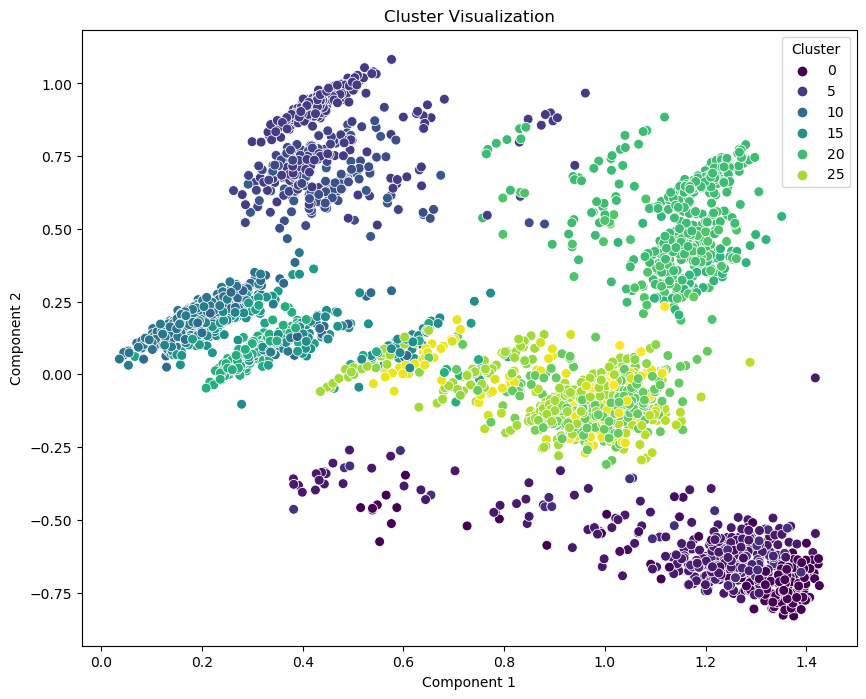

In [48]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

reducer = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
reduced_data = reducer.fit_transform(X_numerical)
combined['Component 1'] = reduced_data[:, 0]
combined['Component 2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=combined, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', s=50)
plt.title('Cluster Visualization')
plt.show()


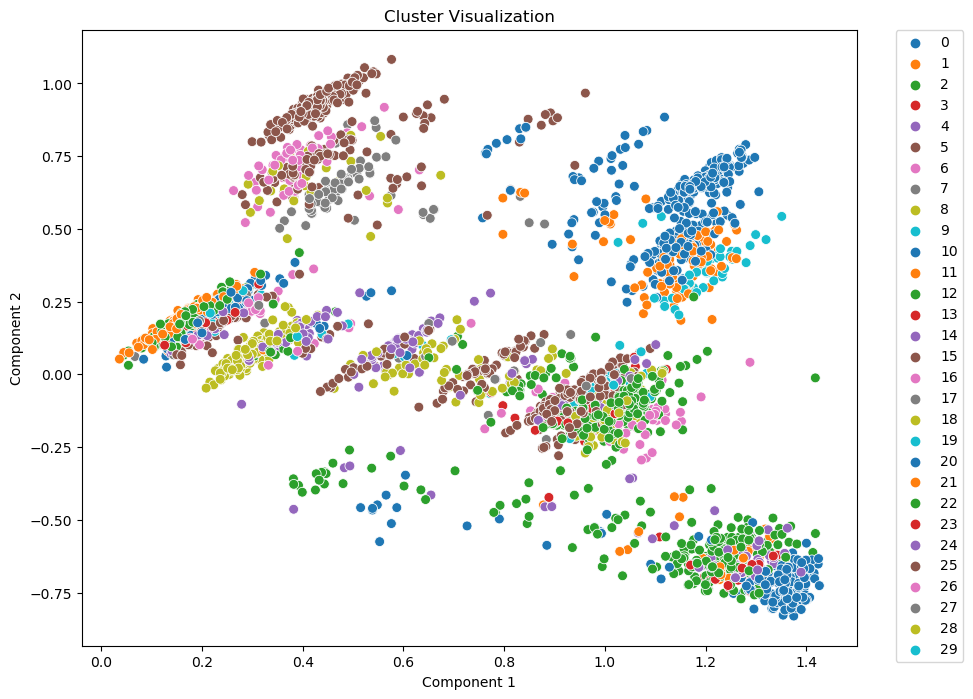

In [49]:
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

reducer = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
reduced_data = reducer.fit_transform(X_numerical)
combined['Component 1'] = reduced_data[:, 0]
combined['Component 2'] = reduced_data[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=combined, x='Component 1', y='Component 2', hue='Cluster', palette='tab10', s=50)
plt.title('Cluster Visualization')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [50]:
mlp_classifier = Pipeline([
    ('selector', pipe),
    ('clf', MLPClassifier(activation='relu', hidden_layer_sizes=112, learning_rate='constant', max_iter=50000, random_state=RANDOM_STATE, solver='adam'))
])

# perform_grid_search(MLPClassifier(), {
#     'hidden_layer_sizes': range(110, 113),
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'learning_rate': ['constant', 'adaptive', 'invscaling'],
#     'max_iter': [50000],
#     'random_state': [RANDOM_STATE]
# }, 5, 3, X=pipe.fit_transform(X_labeled))
checkpoint2.validate_model(mlp_classifier, 5, X_labeled, y_labeled)

array([0.89586777, 0.61105263, 0.70711191, 0.64604757])

In [51]:
knn_classifier = Pipeline([
    ('selector', numerical_transformer),
    ('clf', KNeighborsClassifier(n_neighbors=17))
])

perform_grid_search(knn_classifier, {
    'clf__n_neighbors': range(2, 20)
}, 5, 3)
checkpoint2.validate_model(knn_classifier, 5, X_labeled, y_labeled)

{'clf__n_neighbors': 17}
0.8991735537190083


array([0.89917355, 0.81526316, 0.6664518 , 0.72663906])

In [78]:
from sklearn.ensemble import StackingClassifier, VotingClassifier


voting = VotingClassifier([
    ('mb', multinomial_classifier),
    ('dt', dt_classifier),
    ('knn', knn_classifier)
], weights=[0.4, 0.4, 0.2], voting='soft')
print(checkpoint2.validate_model(voting, 5, X_labeled, y_labeled))

stacking = StackingClassifier([
    ('svc', svm_classifier),
    ('mb', multinomial_classifier),
    ('dt', dt_classifier),
    ('knn', knn_classifier)
], cv=5)
print(checkpoint2.validate_model(stacking, 5, X_labeled, y_labeled))

[0.89917355 0.67105263 0.7200881  0.67691975]
[0.89090909 0.72210526 0.65792892 0.67780019]


In [54]:
num_splits = 5
scores = np.array([
    ["Support Vector Classifier", *checkpoint2.validate_model(svm_classifier, num_splits, X_labeled, y_labeled)],
    ["Multinomial Naive Bayes Classifier",  *checkpoint2.validate_model(multinomial_classifier, num_splits, X_labeled, y_labeled)],
    ["Decision Tree Classifier", *checkpoint2.validate_model(dt_classifier, num_splits, X_labeled, y_labeled)],
    ["MLP Classifier", *checkpoint2.validate_model(mlp_classifier, num_splits, X_labeled, y_labeled)],
    [f"KNN Classifier (k={knn_classifier.get_params()['clf__n_neighbors']})", *checkpoint2.validate_model(knn_classifier, num_splits, X_labeled, y_labeled)],
    ["Stacking Classifier (svc, mb, dt, knn)", *checkpoint2.validate_model(stacking, num_splits, X_labeled, y_labeled)],
    ["Voting Classifier (mb, dt, knn)", *checkpoint2.validate_model(voting, num_splits, X_labeled, y_labeled)]
])
scores = scores[scores[:, 4].argsort()[::-1]]

print(tabulate(scores, headers=['Classifier', 'Average Accuracy', 'Average Recall', 'Average Precision', 'Average F1']))

Classifier                                Average Accuracy    Average Recall    Average Precision    Average F1
--------------------------------------  ------------------  ----------------  -------------------  ------------
Decision Tree Classifier                          0.897521          1                    0.6215        0.764211
Voting Classifier (svc, mb, dt, knn)              0.900826          0.814737             0.672409      0.730366
KNN Classifier (k=17)                             0.899174          0.815263             0.666452      0.726639
Support Vector Classifier                         0.895868          0.804737             0.65801       0.718147
Stacking Classifier (svc, mb, dt, knn)            0.890909          0.722105             0.657929      0.6778
Multinomial Naive Bayes Classifier                0.899174          0.590526             0.73716       0.648255
MLP Classifier                                    0.895868          0.611053             0.707112      0.6

,# Reviews By User,Invited,Review Title,Review Body,Rating,Final Verdict,Final Verdict Class Probability
597,3,1,Drivers were prompt and courteous,drivers were prompt and courteous. skills were excellent through heavy traffic.,5,0,0.997578
215,1,1,I dont like how the booking fee is alot…,i dont like how the booking fee is alot and when i choose to get a uber it varies in prices sometimes its way cheaper to call a cab and when i do then uber sends a notification they lowered the price. also alot of the drivers never like dropping me off at my door especially when i have groceries. they wont even try to back in.,3,1,0.714588
278,3,1,Driver’s were polite and on time,driver’s were polite and on time. smooth ride both to and from airport home,5,0,0.992647
173,3,0,Very disappointed,"on the 23th of january 2023 i rented a uber from oakwood to baker street enfied it was 10 pounds 98 pens. before the driver arriced the pickup point he started texting "" im waiting, im waiting"" i was outside, he arrived minutes later, when i reached home and checked it was 16 pounds and 50pens, so i made a claim, they apologized as they were charging the waiting time and u got my money back isn't it something pre calculated? .....very disappointed.",1,1,0.561564
411,2,1,Safe and easy to use,"booked a taxi for my son and was able to track it arriving and it’s whole journey home. very safe, easy to use system, the car was very clean and driver polite.",5,0,0.997716


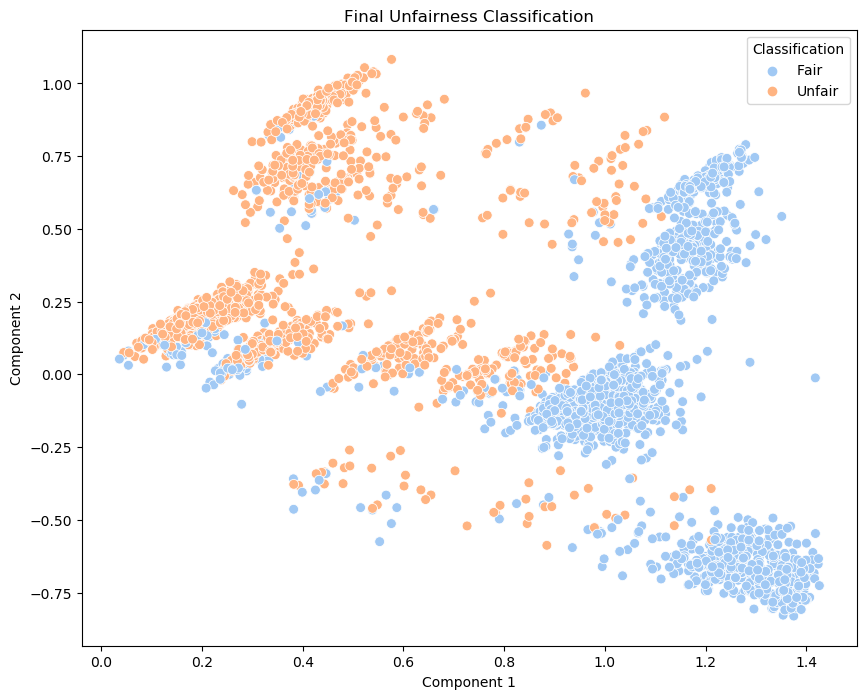

In [123]:
import seaborn as sns
from IPython.display import display

ALREADY_PREPROCESSED = False
test_sample = raw_uber.sample(5)
test_sample["Final Verdict"] = voting.predict(test_sample)
test_sample["Final Verdict Class Probability"] = np.max(voting.predict_proba(test_sample), axis=1)
ALREADY_PREPROCESSED = True

cols = ["# Reviews By User", "Invited", "Review Title", "Review Body", "Rating", "Final Verdict", "Final Verdict Class Probability"]
display(HTML(tabulate(test_sample.loc[:, cols], headers=cols, tablefmt='html')))


combined['Final Verdict'] = voting.predict(combined.loc[:, ~combined.columns.isin(['Component 1', 'Component 2'])])
plt.figure(figsize=(10, 8))
sns.scatterplot(data=combined, x='Component 1', y='Component 2', hue=['Unfair' if verdict else 'Fair' for verdict in combined['Final Verdict']], palette='pastel', s=50)
plt.title('Final Unfairness Classification')
plt.legend(title="Classification")
plt.show()
